# Stock predict
평가 산식: NMAE * 100


평가 (Public, Private score)
- public score: 11월 1일 ~ 11월 5일 주식 종료 예측값
- private score: 11월 29일 ~ 12월 3일 주식 종료 예측값

In [1]:
!pip install finance-datareader

In [2]:
# !pip install OpenDartReader

In [3]:
# for colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/Colab_Notebooks/dacon/stockpredict

/content/drive/MyDrive/Colab_Notebooks/dacon/stockpredict


---------------

In [5]:
import pandas as pd
import numpy as np
import os
import joblib
import FinanceDataReader as fdr
# import OpenDartReader
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# for LSTM model

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.models import load_model

# **Utility functions

In [7]:
def nmae(y_true, y_pred):
  """
  Normalized Mean Absoulte Error * 100

  Returns:
    eval_name, eval_result, is_higher_better
  """
  mae = mean_absolute_error(y_true, y_pred)
  abs_mean = np.mean(np.abs(y_true))
  return "NMAE", (mae / abs_mean) * 100, False

# ADF test
def adf_test(data):
  result = adfuller(data)
  print(f'Test Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'critical_values: {result[4]}')

def plot_two_y_axis(first_data, second_data, f_name="first", s_name="second"):
  # create figure and axis objects with subplots()
  fig,ax = plt.subplots()
  # make a plot
  ax.plot(first_data, color="red")
  # set x-axis label
  ax.set_xlabel("date")
  fig.autofmt_xdate(rotation=45)
  # set y-axis label
  ax.set_ylabel(f_name,color="red")

  # twin object for two different y-axis on the sample plot
  ax2=ax.twinx()
  # make a plot with different y-axis using second axis object
  ax2.plot(second_data, color="blue")
  ax2.set_ylabel(s_name,color="blue")
  plt.show()

In [8]:
path = './'
list_name = 'stock_list.csv'
stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI
...,...,...,...
365,맘스터치,220630,KOSDAQ
366,다날,064260,KOSDAQ
367,제이시스메디칼,287410,KOSDAQ
368,크리스에프앤씨,110790,KOSDAQ


In [24]:
start_date = '20210104'
end_date = '20211126'
sample_code = '005930'
stock = fdr.DataReader(sample_code, start = start_date, end = end_date)
stock

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,0.024691
2021-01-05,81600,83900,81600,83900,35335669,0.010843
2021-01-06,83300,84500,82100,82200,42089013,-0.020262
2021-01-07,82800,84200,82700,82900,32644642,0.008516
2021-01-08,83300,90000,83000,88800,59013307,0.071170
...,...,...,...,...,...,...
2021-11-22,73300,75200,73000,74900,27506623,0.051966
2021-11-23,76000,76000,74500,75300,22029195,0.005340
2021-11-24,76000,76200,74100,74800,15652305,-0.006640


- Change : ROC를 의미? (Price Rate of Change)
  - momentum이라고도 불리는 듯 : ( (금일 종가 - N일전 종가) / N일전 종가 ) * 100
  - 주가가 변동성이 있을때만 의미있는 지표

In [49]:
fdr.chart.plot(stock)

In [ ]:
# volume의 어제자와 차이(1차분)
fdr.chart.plot(stock)

In [ ]:
# volume의 지난주와이 차이(5칸 간격의 1차분)
fdr.chart.plot(stock)

In [ ]:
start_weekday = pd.to_datetime(start_date).weekday()
max_weeknum = pd.to_datetime(end_date).strftime('%V')
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq='B'), columns = ['Date'])

print(f'WEEKDAY of "start_date" : {start_weekday}')
print(f'WEEKDAY of "end_date" : {pd.to_datetime(end_date).weekday()}')
print(f'NUM of WEEKS to "end_date" : {max_weeknum}')
print(f'HOW MANY "Business_days" : {Business_days.shape}', )
display(Business_days.head())

WEEKDAY of "start_date" : 0
WEEKDAY of "end_date" : 4
NUM of WEEKS to "end_date" : 46
HOW MANY "Business_days" : (230, 1)


,Date
0,2021-01-04
1,2021-01-05
2,2021-01-06
3,2021-01-07
4,2021-01-08


In [ ]:
# 이미 영업일만 가져오는듯

# bday_idx = Business_days["Date"]
# bday_stock = stock.reindex(stock.index.intersection(bday_idx))
# fdr.chart.plot(bday_stock)

# OpenDART 기업 재무재표


In [ ]:
# https://opendart.fss.or.kr/
api_key = '8e8ab3b65172cf119b55c60984b4f7451b1e3b6b'
dart = OpenDartReader(api_key)

[OpenDART 개발가이드](https://opendart.fss.or.kr/guide/detail.do?apiGrpCd=DS003&apiId=2019017)

|키|명칭|설명|
|---|---|---|
|corp_code|고유번호|공시대상회사의 고유번호(8자리)|
|bsns_year|사업연도|사업연도(4자리) ※ 2015년 이후 부터 정보제공|
|reprt_code|보고서코드|1분기보고서 : 11013|
|||반기보고서 : 11012|
|||3분기보고서 : 11014|
|||사업보고서 : 11011|

In [ ]:
dart.finstate_all(corp=stock_list.loc[0, '종목코드'], bsns_year=2021, reprt_code=11012)

,rcept_no,reprt_code,bsns_year,corp_code,sj_div,sj_nm,account_id,account_nm,account_detail,thstrm_nm,thstrm_amount,frmtrm_nm,frmtrm_amount,ord,thstrm_add_amount,frmtrm_q_nm,frmtrm_q_amount,frmtrm_add_amount
0,20210817001416,11012,2021,00126380,BS,재무상태표,ifrs-full_CurrentAssets,유동자산,-,제 53 기 반기말,191118524000000,제 52 기말,198215579000000,1,NaN,NaN,NaN,NaN
1,20210817001416,11012,2021,00126380,BS,재무상태표,ifrs-full_CashAndCashEquivalents,현금및현금성자산,-,제 53 기 반기말,30683788000000,제 52 기말,29382578000000,2,NaN,NaN,NaN,NaN
2,20210817001416,11012,2021,00126380,BS,재무상태표,dart_ShortTermDepositsNotClassifiedAsCashEquiv...,단기금융상품,-,제 53 기 반기말,77777032000000,제 52 기말,92441703000000,3,NaN,NaN,NaN,NaN
3,20210817001416,11012,2021,00126380,BS,재무상태표,-표준계정코드 미사용-,단기상각후원가금융자산,-,제 53 기 반기말,2350399000000,제 52 기말,2757111000000,4,NaN,NaN,NaN,NaN
4,20210817001416,11012,2021,00126380,BS,재무상태표,ifrs-full_CurrentFinancialAssetsAtFairValueThr...,단기당기손익-공정가치금융자산,-,제 53 기 반기말,49720000000,제 52 기말,71451000000,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,20210817001416,11012,2021,00126380,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업 소유주지분|기타자본항목,제 53 기 반기,-6226066000000,NaN,NaN,13,NaN,제 52 기 반기,-3721095000000,NaN
180,20210817001416,11012,2021,00126380,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업 소유주지분|매각예정분류기타자본항목,제 53 기 반기,0,NaN,NaN,13,NaN,제 52 기 반기,0,NaN
181,20210817001416,11012,2021,00126380,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업 소유주지분|이익잉여금 [member],제 53 기 반기,275085185000000,NaN,NaN,13,NaN,제 52 기 반기,260165053000000,NaN
182,20210817001416,11012,2021,00126380,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업 소유주지분|자본금 [member],제 53 기 반기,897514000000,NaN,NaN,13,NaN,제 52 기 반기,897514000000,NaN


# 검색어 트랜드 살피기

- google trend
- 크롤링 자동화는 데이터를 살펴 본 다음에..

In [ ]:
df_trend = pd.read_csv("./google_trend_samsung.csv", header=1, index_col=0)
df_trend.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 2020-11-29 to 2021-11-14
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   삼성전자: (대한민국)  51 non-null     int64
dtypes: int64(1)
memory usage: 816.0+ bytes


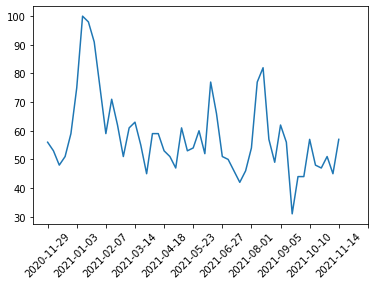

In [ ]:
plt.plot(df_trend)
plt.xticks(np.arange(0,60,5), rotation=45)
plt.show()

##0) Baseline code 따라하기
요일별 종가("Closed")를 linear regression로 예측
- 이번주 데이터로 다음주 예측

In [ ]:
sample_code = stock_list.loc[0,'종목코드']

sample = fdr.DataReader(sample_code, start = start_date, end = end_date)[['Close']].reset_index()
sample = pd.merge(Business_days, sample, how = 'outer')
sample['weekday'] = sample.Date.apply(lambda x : x.weekday())
sample['weeknum'] = sample.Date.apply(lambda x : x.strftime('%V'))
sample.Close = sample.Close.ffill()
sample = pd.pivot_table(data = sample, values = 'Close', columns = 'weekday', index = 'weeknum')
sample.head()

weekday,0,1,2,3,4
weeknum,,,,,
02,55500.0,55800.0,56800.0,58600.0,59500.0
03,60000.0,60000.0,59000.0,60700.0,61300.0
04,62400.0,61400.0,62300.0,60800.0,60800.0
05,60800.0,58800.0,59100.0,57200.0,56400.0
06,57200.0,58900.0,59500.0,61100.0,60400.0


In [ ]:
sample.tail()

weekday,0,1,2,3,4
weeknum,,,,,
48,67500.0,67700.0,66600.0,68000.0,68200.0
49,66700.0,67800.0,69500.0,69700.0,71500.0
50,72900.0,71700.0,73900.0,72900.0,73400.0
51,73800.0,73800.0,73800.0,73300.0,73000.0
52,73000.0,72300.0,73900.0,77800.0,77800.0


In [ ]:
x = sample.iloc[0:-2].to_numpy()
x.shape

(49, 5)

In [ ]:
y = sample.iloc[1:-1].to_numpy()
y_0 = y[:,0]
y_1 = y[:,1]
y_2 = y[:,2]
y_3 = y[:,3]
y_4 = y[:,4]

y_values = [y_0, y_1, y_2, y_3, y_4]

In [ ]:
x_public = sample.iloc[-2].to_numpy()

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

predictions = []
for y_value in y_values :
    model.fit(x,y_value)
    prediction = model.predict(np.expand_dims(x_public,0))
    predictions.append(prediction[0])

In [ ]:
print(f"y_pred : {predictions}\nvs\ny_public : {list(sample.iloc[-1].values)}")

y_pred : [73912.14870585549, 73508.90894414231, 73858.77902491373, 73367.23881923566, 73322.49774082401]
vs
y_public : [73000.0, 72300.0, 73900.0, 77800.0, 77800.0]


In [ ]:
nmae(list(sample.iloc[-1].values), predictions)

# 1) LightGBM
- feature를 만들어서 lgbm regression으로 시도해본다.
- hyperparams는 grid search나 bayesian optimization을 시도해본다.
- 성능이 안좋더라도, feature importance를 통해 feature의 효용성을 확인해본다.

In [ ]:
from lightgbm import LGBMRegressor

### features & preprocess
- 시가 ~ 종가 : Change
- Volume : 추세를 나타내는게 효과적일 듯?
- High ~ Low : 
- 상승 or 하락? : Change 수치로 대체될듯

In [ ]:
data = stock.copy()

In [ ]:
X = data[["Change","Close","Volume"]]

In [ ]:
# 미래 1주일 뒤(=각 날짜마다 5일 뒤)를 예측? -> 단순 다음주는 x.. 너무 naive한 접근법인듯. 그러나 어찌되었든 5일 후까지를 예측하는 문제이니, 5칸 영역 밖에서 해결해야한다.
# 어쨌든 중요한 점은 X feature에 최근 흐름을 담아야함
y = data["Close"].shift(-5).dropna()
y_train = y.iloc[:-20]
y_test = y.iloc[-20:]

In [ ]:
X_train = X.reindex(X.index.intersection(y_train.index))
X_test = X.reindex(X.index.intersection(y_test.index))

### model

In [ ]:
lgbm_model = LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
lgbm_model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=nmae,
        early_stopping_rounds=5)

[1]	valid_0's l2: 2.74411e+08	valid_0's NMAE: 0.226885
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 2.65491e+08	valid_0's NMAE: 0.223077
[3]	valid_0's l2: 2.57597e+08	valid_0's NMAE: 0.219651
[4]	valid_0's l2: 2.50545e+08	valid_0's NMAE: 0.216536
[5]	valid_0's l2: 2.44132e+08	valid_0's NMAE: 0.213663
[6]	valid_0's l2: 2.37193e+08	valid_0's NMAE: 0.21052
[7]	valid_0's l2: 2.31073e+08	valid_0's NMAE: 0.207708
[8]	valid_0's l2: 2.25622e+08	valid_0's NMAE: 0.205163
[9]	valid_0's l2: 2.19866e+08	valid_0's NMAE: 0.202449
[10]	valid_0's l2: 2.15208e+08	valid_0's NMAE: 0.200216
[11]	valid_0's l2: 2.10833e+08	valid_0's NMAE: 0.198095
[12]	valid_0's l2: 2.06815e+08	valid_0's NMAE: 0.196159
[13]	valid_0's l2: 2.0292e+08	valid_0's NMAE: 0.194231
[14]	valid_0's l2: 1.98536e+08	valid_0's NMAE: 0.192051
[15]	valid_0's l2: 1.94417e+08	valid_0's NMAE: 0.189979
[16]	valid_0's l2: 1.91128e+08	valid_0's NMAE: 0.188331
[17]	valid_0's l2: 1.87703e+08	valid_0's NMAE: 0.18657

LGBMRegressor(learning_rate=0.05, n_estimators=20)

In [ ]:
y_pred = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration_)
# eval
print('NMAE * 100 :', (nmae(y_test, y_pred))[1])

# feature importances
print(
    'Feature importances:', 
    [pair for pair in zip(X.columns, list(lgbm_model.feature_importances_))]
)

NMAE * 100 : 18.237378574862305
Feature importances: [('Change', 20), ('Close', 96), ('Volume', 37)]


-> validation set에서는 성능이 잘나오는데, 테스트셋의 성능이 최악이다.

-> feature를 전혀 가공하지 않았기 때문도 있지만, 문제 정의 자체가 힘든 듯 : 1일 후~ 5일 후까지 예측 필요. 베이스라인 코드와 같이, 1일후 모델 ~ 5일후 모델 총 5개를 만들어도 되겠으나, 개별적인 데이터 모델링이 필요해보인다.

# 2) Sequence model
- 모델은 간단한 LSTM을 쓰고, 추후에 다른 시퀀스나 어탠션을 넣어본다.
- DNN 레이어 자체보다는, 데이터 가공에 신경써보자

In [10]:
## X sequence size, Y sequence size 정의
step_size = 30 # 약 6주치
unit_size = 5 # 총 5일 예측할 것임

"""
L : total length
W : x step size(input sequence Window size)
P : y unit size(Predicting sequence size)일때,

=> W만큼 X데이터 시퀀스를 넣어 P만큼의 시퀀스 길이를 예측한다.

X data shape : (L-W+1, W, num_features)
Y data shape : (L-W-P+1, P)
"""

'\nL : total length\nW : x step size(input sequence Window size)\nP : y unit size(Predicting sequence size)일때,\n\n=> W만큼 X데이터 시퀀스를 넣어 P만큼의 시퀀스 길이를 예측한다.\n\nX data shape : (L-W+1, W, num_features)\nY data shape : (L-W-P+1, P)\n'

** trend 분석 및 변수로 추가하기

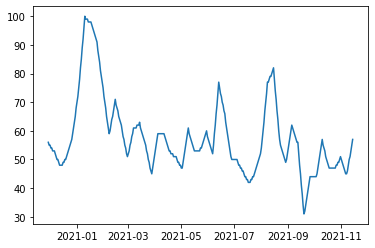

In [ ]:
# trend를 동일 인덱스로 맞추기 위한 가공
df_trend.index = df_trend.index.astype("datetime64[ns]")
df_trend = df_trend.resample("D").asfreq()
df_trend = df_trend.interpolate().astype(int)
plt.plot(df_trend)
plt.show()

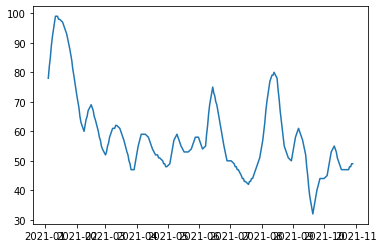

In [ ]:
df_trend = df_trend.reindex(Business_days["Date"].astype("datetime64[ns]"))
plt.plot(df_trend)
plt.show()

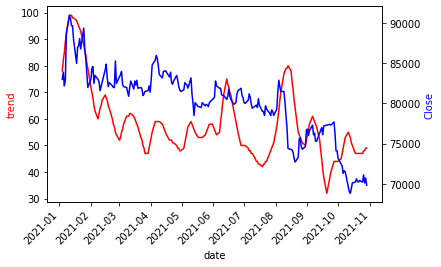

In [ ]:
plot_two_y_axis(df_trend, stock["Close"], "trend", "Close")

In [ ]:
# pd series로 만들기
df_trend = df_trend[df_trend.columns[0]]

In [ ]:
# index 맞추기
common_idx = stock["Close"].index.intersection(df_trend.index)
df_trend = df_trend.reindex(common_idx)

In [25]:
# Correlation 확인
# 여러가지 컬럼을 가공 및 믹스한 feature를 만들어내본다
df_test = stock.copy()
df_test["HL"] = df_test["High"] - df_test["Low"] # High - Low 차이
df_test["OC"] = (df_test["Open"] - df_test["Close"]).abs() # Open, Close 차이
# df_test["band"] = df_test["OC"] / df_test["HL"] # High~Low 대비 Open~Close
df_test["band"] = df_test["Close"] / df_test["Open"] # High~Low 대비 Open~Close
# df_test["Voldiff"] = (df_test["Volume"] - df_test["Volume"].shift(1)).interpolate().astype(int) # Volume 1차분


In [ ]:
# trend 넣어보기
df_test = pd.concat([df_test, df_trend], axis=1)

In [31]:
# time diff 줘보기
df_test = df_test.shift(5)
df_test["Close"] = stock["Close"]
df_test = df_test.dropna()

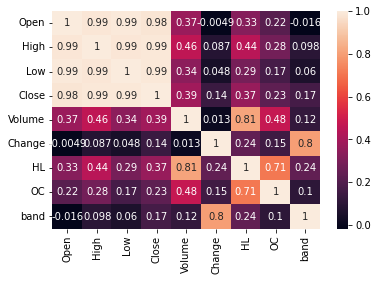

In [34]:
sns.heatmap(df_test.corr(method="pearson"), annot=True)

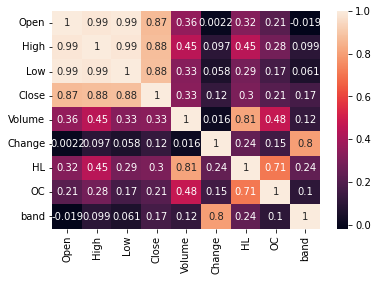

In [32]:
sns.heatmap(df_test.corr(method="pearson"), annot=True)

==> correlation은 큰 의미는 없는듯하다.. Open, High, Low 전부 Close와 유사한 형태로 따라가기때문에 correlation이 높게나오는건 당연한게 아닐까?

### correlation 등 두 시계열의 synchrony를 확인하는 방법 :

[four-ways-to-quantify-synchrony-between-time-series-data](https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9)

1. 피어슨 상관계수 : simple is best
2. TLCC(Time Lagged Cross Corr), WTLCC(Windowed~)
3. DTW(Dynamic Time Warping)
4. Instantaneous phase synchrony

이 중 과거 시간대의 데이터를 활용해 미래 시간예측을 하기 위해, 2번의 방법을 시도해본다. TLCC 방법 중엔 대표적으로 아래에 granger causality test가 있다.

- 참고: 인과관계 분석에서 인과관계를 보여도, 실제 현실세계에서 인과관계를 갖는다는 증거가 되지 않음에 유의하자

Test Statistics: -13.660246469977183
p-value: 1.5262756766053516e-25
critical_values: {'1%': -3.4631437906252636, '5%': -2.8759570379821047, '10%': -2.574454682874228}
Test Statistics: -6.8477958618359684
p-value: 1.724910001233379e-09
critical_values: {'1%': -3.463987334463603, '5%': -2.8763259091636213, '10%': -2.5746515171738515}
Test Statistics: -3.135581701047719
p-value: 0.02402960974968417
critical_values: {'1%': -3.463987334463603, '5%': -2.8763259091636213, '10%': -2.5746515171738515}


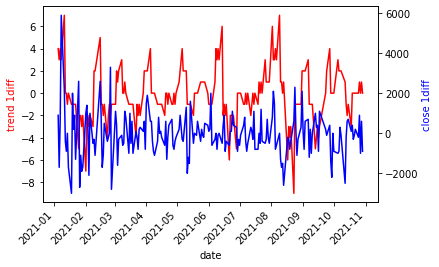

In [ ]:
close_diff = (stock["Close"] - stock["Close"].shift(1)).dropna()
adf_test(close_diff)
trend_diff = (df_trend - df_trend.shift(1)).dropna()
adf_test(trend_diff)
adf_test(df_trend)
plot_two_y_axis(trend_diff, close_diff, "trend 1diff", "close 1diff")

### granger causality test

[참고 : granger-causality-in-time-series-explained-using-chicken-and-egg](https://www.analyticsvidhya.com/blog/2021/08/granger-causality-in-time-series-explained-using-chicken-and-egg-problem/)

그레인저 인과관계 분석은 정상 데이터들에 한해서 분석이 가능하다. ADF 테스트와 1차분, 2차분, ..을 이어나가며 정상 데이터를 확보하자.

In [ ]:
# 1st causality try : 종가와 트렌드
df_test = pd.concat([close_diff, trend_diff], axis=1)
grangercausalitytests(df_test, maxlag=6)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0003  , p=0.9870  , df_denom=199, df_num=1
ssr based chi2 test:   chi2=0.0003  , p=0.9869  , df=1
likelihood ratio test: chi2=0.0003  , p=0.9869  , df=1
parameter F test:         F=0.0003  , p=0.9870  , df_denom=199, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0873  , p=0.9164  , df_denom=196, df_num=2
ssr based chi2 test:   chi2=0.1791  , p=0.9143  , df=2
likelihood ratio test: chi2=0.1791  , p=0.9144  , df=2
parameter F test:         F=0.0873  , p=0.9164  , df_denom=196, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5884  , p=0.6233  , df_denom=193, df_num=3
ssr based chi2 test:   chi2=1.8292  , p=0.6086  , df=3
likelihood ratio test: chi2=1.8209  , p=0.6104  , df=3
parameter F test:         F=0.5884  , p=0.6233  , df_denom=193, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4451  , p=0.2207  

{1: ({'lrtest': (0.00026876789661400835, 0.9869199530150145, 1),
   'params_ftest': (0.00026477647051643315, 0.9870337347729011, 199.0, 1.0),
   'ssr_chi2test': (0.00026876807553579925, 0.9869199486616386, 1),
   'ssr_ftest': (0.00026477647045358444, 0.9870337347739829, 199.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (0.17906662106361182, 0.9143578068722094, 2),
   'params_ftest': (0.08734501488282854, 0.9163965311120498, 196.0, 2.0),
   'ssr_chi2test': (0.17914640807600987, 0.9143213306609596, 2),
   'ssr_ftest': (0.08734501488283068, 0.9163965311120498, 196.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (1.8209159207035555, 0.6103940088591946, 3),
   'params_ftest': (0.5884024685000099, 0.6232996698359337, 193.0, 3.0),
   'ssr_chi2test': (1.8292304720207244, 0.6085948094723928, 3),
   'ssr_ftest': (0.5884024684999997, 0.6232996698359432, 193.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
   

In [ ]:
# 2nd causality try : 트렌드와 종가
df_test = pd.concat([trend_diff, close_diff], axis=1)
grangercausalitytests(df_test, maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1398  , p=0.0779  , df_denom=199, df_num=1
ssr based chi2 test:   chi2=3.1871  , p=0.0742  , df=1
likelihood ratio test: chi2=3.1622  , p=0.0754  , df=1
parameter F test:         F=3.1398  , p=0.0779  , df_denom=199, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1786  , p=0.1159  , df_denom=196, df_num=2
ssr based chi2 test:   chi2=4.4683  , p=0.1071  , df=2
likelihood ratio test: chi2=4.4194  , p=0.1097  , df=2
parameter F test:         F=2.1786  , p=0.1159  , df_denom=196, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6199  , p=0.1861  , df_denom=193, df_num=3
ssr based chi2 test:   chi2=5.0359  , p=0.1692  , df=3
likelihood ratio test: chi2=4.9735  , p=0.1737  , df=3
parameter F test:         F=1.6199  , p=0.1861  , df_denom=193, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6062  , p=0.1744  

{1: ({'lrtest': (3.162226729928875, 0.07536032708145732, 1),
   'params_ftest': (3.1397747858245473, 0.07793461498341314, 199.0, 1.0),
   'ssr_chi2test': (3.187108074052904, 0.07422120592276771, 1),
   'ssr_ftest': (3.1397747858243963, 0.07793461498342177, 199.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (4.419386999680796, 0.10973427693508458, 2),
   'params_ftest': (2.178588547827277, 0.11593495245635797, 196.0, 2.0),
   'ssr_chi2test': (4.468329572585088, 0.107081528474838, 2),
   'ssr_ftest': (2.1785885478275553, 0.1159349524563255, 196.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (4.973517636682232, 0.17374661557647242, 3),
   'params_ftest': (1.6198725250742936, 0.18610626310846332, 193.0, 3.0),
   'ssr_chi2test': (5.03587313494312, 0.1691891047662597, 3),
   'ssr_ftest': (1.6198725250733703, 0.18610626310867437, 193.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 

==> 유의미한 결과나, 유의미한 p-value(<0.05)를 보여주지 못했다. 

* 트렌드가 종가의 cause가 되는것보단, 종가가 트렌드의 cause가 되는 경향이 있다.
  * lag=1 즉 매우 가까운 거리에서 그나마 p-value가 0.05에 근접했다.
* 결론 : 미래 1일후의 검색 트렌드를 안다면.. 종가를 예측해볼수있다..
* p-value가 높지만 그나마 lag=5 즉 5일전 검색트렌드가 약간은 종가에 대한 원인 관계를 보여주는 편이다

### TLCC(Time-Lag Cross Correlation)

시간을 밀어가며 확인해보자.

cross-correlation 해석 및 다루기 : https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/cross-correlation/interpret-the-results/all-statistics-and-graphs/

In [24]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.shift(lag).dropna().corr(datay.shift(lag).dropna())

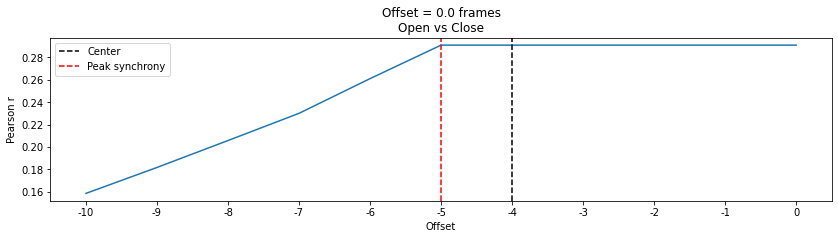

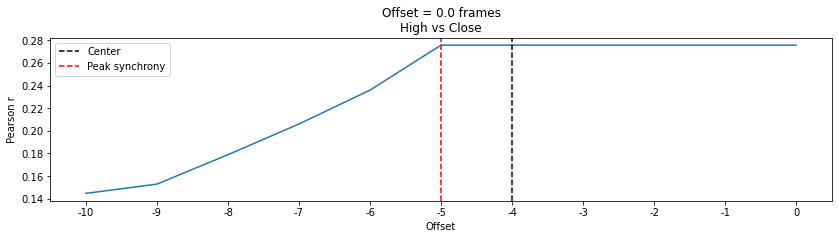

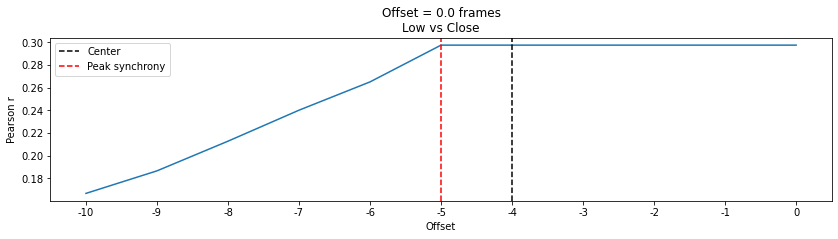

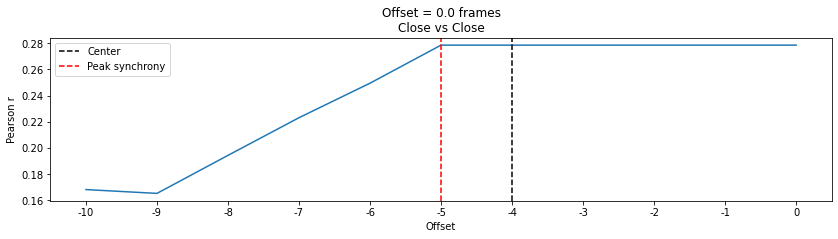

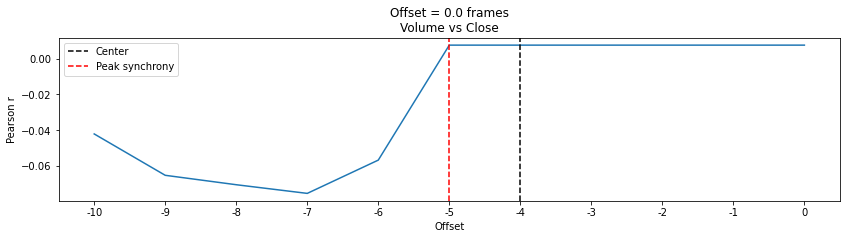

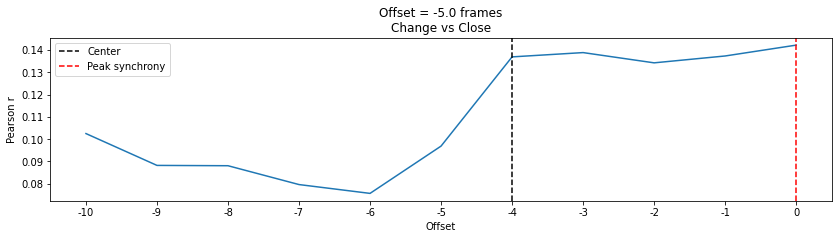

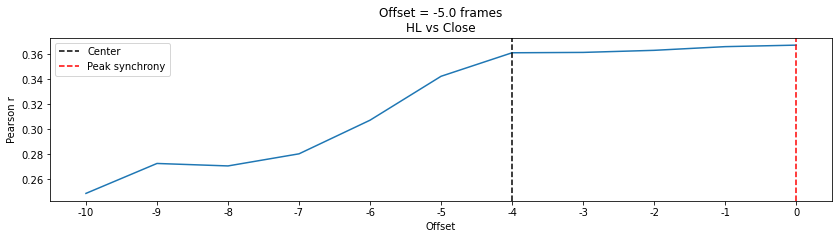

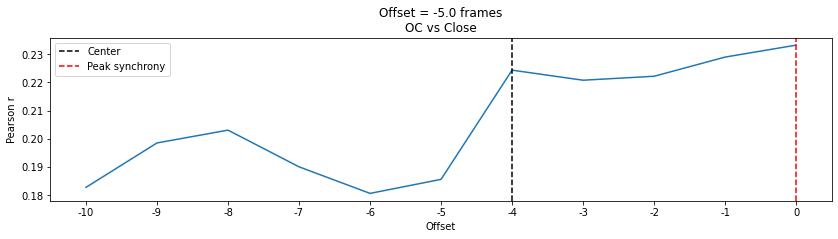

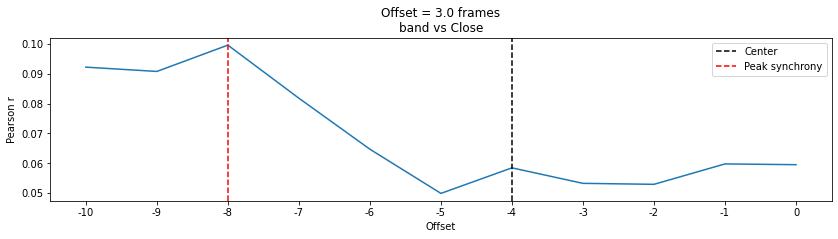

In [27]:
df_diff = df_test.copy()
d2 = df_diff["Close"]
df_diff[["Open","High","Low","Close","Volume"]] = (df_diff - df_diff.shift(5)).dropna()[["Open","High","Low","Close","Volume"]] # timedelta=1
for col in df_diff.columns:
  d1 = df_diff[col]
  xticks = list(range(-10,1))
  rs = [crosscorr(d1,d2, lag) for lag in xticks]
  offset = np.floor(len(rs)/2)-np.argmax(rs)
  f,ax=plt.subplots(figsize=(14,3))
  ax.plot(rs)
  ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
  ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
  ax.set(title=f'Offset = {offset} frames\n{col} vs Close', xlabel='Offset',ylabel='Pearson r')
  ax.set_xticks(range(len(xticks)))
  ax.set_xticklabels(xticks);
  plt.legend()

### WTLCC(Windowed Time-Lag Cross Correlation)

pandas rolling에도 correlation 기능을 제공한다.

- 참고 : https://www.statology.org/rolling-correlation-pandas/
- 문서 : https://pandas.pydata.org/docs/reference/api/pandas.core.window.rolling.Rolling.corr.html

In [ ]:
# Rolling window time lagged cross correlation
seconds = 5
fps = 30
window_size = 300 #samples
t_start = 0
t_end = t_start + window_size
step_size = 30
rss=[]
while t_end < 5400:
    d1 = df['S1_Joy'].iloc[t_start:t_end]
    d2 = df['S2_Joy'].iloc[t_start:t_end]
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)

In [ ]:
# df_test = stock.copy()
print(f"window size : {step_size} | predict forward : {unit_size}")
df_temp = pd.DataFrame(np.nan, columns=df_test.columns, index=df_test.index[step_size-1:-unit_size])
for col in df_test.columns:
  temp = df_test[col].rolling(step_size).corr(df_test["Close"].shift(-unit_size)) # 과거 30일치로 다음주 5일 후를 살펴보자
  df_temp[col] = temp.dropna()

# lags = [15, 20, 25, 30, 35, 40]

# df_corr = pd.DataFrame.from_dict(
#     {x: 
#      [df_test[col].rolling(step).corr(df_test["Close"].shift(-unit_size)).dropna().values for step in lags]
#      for x in df_test.columns
#     }
# )

window size : 30 | predict forward : 5


In [ ]:
df_temp

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-02-16,-0.042377,0.102793,-0.024698,0.129732,0.400621,0.078170
2021-02-17,0.097137,0.204061,0.121859,0.235823,0.424682,0.040947
2021-02-18,0.218311,0.290479,0.219223,0.287508,0.435059,0.002455
2021-02-19,0.327529,0.398683,0.341229,0.422137,0.424085,0.061145
2021-02-22,0.457686,0.518805,0.441526,0.548030,0.459803,0.038336
...,...,...,...,...,...,...
2021-11-08,0.491963,0.530025,0.568567,0.576239,-0.140577,0.130155
2021-11-09,0.293714,0.347967,0.385518,0.401028,-0.123755,0.141046
2021-11-10,0.096480,0.155574,0.188256,0.193318,-0.091580,0.096297


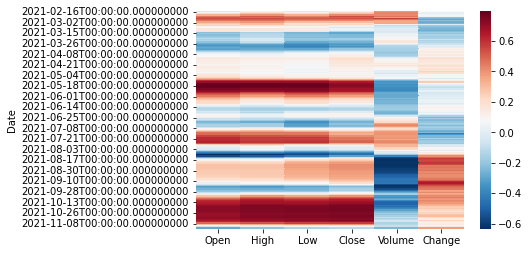

In [ ]:
# fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_temp, cmap='RdBu_r')
# ax.set(title=f'Windowed',xlim=[0,301], xlabel='Offset',ylabel='Epochs')
# ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
# ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);

-> 특정 시간대의 과거 30일치 window의 데이터 vs 다음주 5일 후의 종가의 상관 관계를 나타 낸 것.

-> 


### 위에서 선택한 features로 학습해보기

In [54]:
## Get X data
# X = stock[["Change","Close","Volume"]]
# X = pd.concat([X, df_trend], axis=1)

## X data with trend
# X = df_test[["Close","OC","HL","Volume","Change","삼성전자: (대한민국)"]]

## 2nd tried features
# X = df_test[["Close", "HL", "band"]]

## 3rd tried features
X = df_test[["Close", "HL","band", "Volume"]]
X_temp = X[["Volume"]]
X[["Volume"]] = (X_temp - X_temp.shift(1)).interpolate(limit_direction="both") # B1일전과 1차분. interploate 시 both 방향으로 채워줘야 다 채워짐.
# X = (X - X.shift(1)).interpolate(limit_direction="both") # B1일전과 1차분. ffill과 bfill 둘중 하나만 하면 안채워지는 경우가 있음.

#### temporary checking data
print(X.head())
print(f"total infs : {np.isinf(X).values.sum()}")
print(f"total nans : {X.isna().sum()}")

# if np.isinf(X["Volume"]).values.sum() > 0: # 나눗셈은 분모가 0이면 inf값이 가능
#     X["band"] = X["band"].replace([np.inf, -np.inf], np.nan).interpolate()

            Close    HL      band      Volume
Date                                         
2021-01-04  83000  4200  1.024691  -3319607.0
2021-01-05  83900  2300  1.028186  -3319607.0
2021-01-06  82200  2400  0.986795   6753344.0
2021-01-07  82900  1500  1.001208  -9444371.0
2021-01-08  88800  7000  1.066026  26368665.0
total infs : 0
total nans : Close     0
HL        0
band      0
Volume    0
dtype: int64


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [55]:
# 타겟의 컬럼 순서. 추후 스케일링-역스케일링, reshaping 등등에 활용
TARGET_COL_IDX = list(X.columns).index("Close")

In [56]:
# minmax scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(X.astype('float32'))
df = pd.DataFrame(scaled, columns=X.columns, index=X.index)

In [57]:
# reshaping for LSTM input
X_reshaped, y_reshaped = [], []
for i in range(len(scaled) - step_size - unit_size + 1):
  cur_X = scaled[i:i+step_size,:]
  # X data는 step_size만큼의 window를 확보한다.
  X_reshaped.append(cur_X)
  # y data는 1주일 뒤 예측을 위해 unit_size 간격만큼 밀어놓고, unit_size 만큼의 window를 확보한다.
  cur_y = scaled[i+step_size:i+step_size+unit_size, TARGET_COL_IDX] # Close 컬럼만 뽑아내기
  y_reshaped.append(cur_y)

X_reshaped = np.array(X_reshaped)
y_reshaped = np.array(y_reshaped)

print(f"X reshaped : {X_reshaped.shape}")
print(f"Y reshaped : {y_reshaped.shape}")

X reshaped : (190, 30, 4)
Y reshaped : (190, 5)


In [58]:
# train test split
X_train, y_train = X_reshaped[:-16], y_reshaped[:-16]
X_test, y_test = X_reshaped[-16:], y_reshaped[-16:]
print(f"Train ({X_train.shape[0]}) vs Test ({X_test.shape[0]})")

Train (174) vs Test (16)


In [59]:
# build model
model = Sequential()
model.add(LSTM(units=unit_size, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(unit_size))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5)                 200       
                                                                 
 dense_3 (Dense)             (None, 5)                 30        
                                                                 
Total params: 230
Trainable params: 230
Non-trainable params: 0
_________________________________________________________________


Epoch 1/80
35/35 - 3s - loss: 0.3436 - val_loss: 0.1448 - 3s/epoch - 82ms/step
Epoch 2/80
35/35 - 0s - loss: 0.2788 - val_loss: 0.1352 - 423ms/epoch - 12ms/step
Epoch 3/80
35/35 - 0s - loss: 0.2379 - val_loss: 0.1161 - 435ms/epoch - 12ms/step
Epoch 4/80
35/35 - 0s - loss: 0.2086 - val_loss: 0.1171 - 421ms/epoch - 12ms/step
Epoch 5/80
35/35 - 0s - loss: 0.1788 - val_loss: 0.1178 - 455ms/epoch - 13ms/step
Epoch 6/80
35/35 - 0s - loss: 0.1553 - val_loss: 0.1190 - 425ms/epoch - 12ms/step
Epoch 7/80
35/35 - 0s - loss: 0.1308 - val_loss: 0.1156 - 445ms/epoch - 13ms/step
Epoch 8/80
35/35 - 0s - loss: 0.1131 - val_loss: 0.1154 - 429ms/epoch - 12ms/step
Epoch 9/80
35/35 - 0s - loss: 0.0988 - val_loss: 0.1187 - 426ms/epoch - 12ms/step
Epoch 10/80
35/35 - 0s - loss: 0.0892 - val_loss: 0.1220 - 447ms/epoch - 13ms/step
Epoch 11/80
35/35 - 0s - loss: 0.0806 - val_loss: 0.1223 - 437ms/epoch - 12ms/step
Epoch 12/80
35/35 - 0s - loss: 0.0769 - val_loss: 0.1192 - 496ms/epoch - 14ms/step
Epoch 13/80
35/3

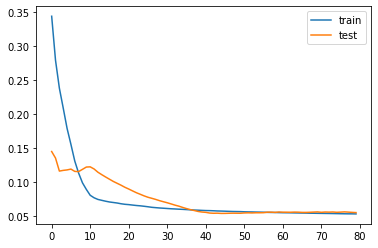

In [60]:
# fitting
history = model.fit(X_train, y_train, epochs=80, batch_size=5, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [61]:
# predict
y_hat = model.predict(X_test)

In [96]:
y_hat

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]], dtype=float32)

In [49]:
y_test

array([[0.04954958, 0.08108115, 0.11711717, 0.11261272, 0.08558559],
       [0.08108115, 0.11711717, 0.11261272, 0.08558559, 0.06306314],
       [0.11711717, 0.11261272, 0.08558559, 0.06306314, 0.10810804]],
      dtype=float32)

In [50]:
y_hat.shape[0]

3

In [62]:
# reverse the reshape for inverse scaling

# yhat_total, ytest_total = [], []
nmae_sum = 0.0
for i in range(y_hat.shape[0]):
  padding = np.zeros((y_hat.shape[1], X_test.shape[2])) # (samples, n_features)

  padding[:, TARGET_COL_IDX] = y_hat[i] # Close 컬럼 채워넣기
  inv_yhat = scaler.inverse_transform(padding)
  inv_yhat = inv_yhat[:, TARGET_COL_IDX]
  # yhat_total.append(inv_yhat)

  padding[:, TARGET_COL_IDX] = y_test[i] # Close 컬럼 채워넣기
  inv_ytest = scaler.inverse_transform(padding)
  inv_ytest = inv_ytest[:, TARGET_COL_IDX]
  # ytest_total.append(inv_ytest)
  cur_nmae = nmae(inv_ytest, inv_yhat)[1]
  nmae_sum += cur_nmae
  print(
      f"NMAE *100 for ({i+1}/{y_hat.shape[0]}) : {cur_nmae}"
      f"\n > y_true : {inv_ytest}"
      f"\n > y_hat  : {inv_yhat}"
  )
print(f"\n== NMAE*100 avg : {nmae_sum/y_hat.shape[0]} ==")
# yhat_total = np.array(yhat_total).reshape(1,-1)
# ytest_total = np.array(ytest_total).reshape(1,-1)

NMAE *100 for (1/16) : 1.257605957369461
 > y_true : [69900.00031013 71499.99931771 70399.99867678 70600.00119917
 70200.00144728]
 > y_hat  : [69424.50563662 69779.22361953 69805.93850114 69422.72631508
 69733.28826105]
NMAE *100 for (2/16) : 1.3370096138280045
 > y_true : [71499.99931771 70399.99867678 70600.00119917 70200.00144728
 70600.00119917]
 > y_hat  : [69566.78280017 69774.19222917 69809.98260168 69528.35334191
 69897.03587692]
NMAE *100 for (3/16) : 0.504861712335222
 > y_true : [70399.99867678 70600.00119917 70200.00144728 70600.00119917
 70500.00258442]
 > y_hat  : [69866.98572883 70265.40671019 70465.27029416 70049.51211318
 70595.26505295]
NMAE *100 for (4/16) : 0.6228428006804733
 > y_true : [70600.00119917 70200.00144728 70600.00119917 70500.00258442
 70200.00144728]
 > y_hat  : [69860.69678033 70116.59687699 70049.85697819 69805.99449002
 70073.83320153]
NMAE *100 for (5/16) : 0.3998981814878605
 > y_true : [70200.00144728 70600.00119917 70500.00258442 70200.00144728

In [176]:
""" 
====== Y값인 Close를 차분했을 경우, 원래 상태의 데이터로 비교하기 ======
"""

# test 데이터는 뒤에서 4개(=20일치) 사용했음
# 1차분 즉, 전날 1일치를 뺀 값이므로 21일 전 ~ 1일전 데이터를 입력한다
test_cnt = len(y_hat)
org_ys = np.array(df_test["Close"].values[-(test_cnt*unit_size)-1:-1]).reshape(test_cnt,5)

for i in range(y_hat.shape[0]):
  padding = np.zeros((y_hat.shape[1], X_test.shape[2])) # (samples, n_features)

  padding[:, TARGET_COL_IDX] = y_hat[i] # Close 컬럼 채워넣기
  inv_yhat = scaler.inverse_transform(padding)
  inv_yhat = inv_yhat[:, TARGET_COL_IDX]

  # padding[:, TARGET_COL_IDX] = y_test[i] # Close 컬럼 채워넣기
  # inv_ytest = scaler.inverse_transform(padding)
  # inv_ytest = inv_ytest[:, TARGET_COL_IDX]

  # 예측값이 1차분 값이다. 원래 데이터로 생성해내기 위해, 예측값을 누적해서 더해본다.
  inv_yhat = np.cumsum(inv_yhat) + org_ys[i][0]
  inv_ytest = org_ys[i]

  print(
      f"NMAE *100 for ({i+1}/{y_hat.shape[0]}) : {nmae(inv_ytest, inv_yhat)[1]}"
      f"\n > y_true : {inv_ytest}"
      f"\n > y_hat  : {inv_yhat}"
  )

NMAE *100 for (1/3) : 1.2555559358681823
 > y_true : [69800 69900 71500 70400 70600]
 > y_hat  : [69739.90999146 69566.05666813 69581.69578851 69487.04677736
 69403.22276842]
NMAE *100 for (2/3) : 0.49164534718134634
 > y_true : [70200 70600 70500 70200 69900]
 > y_hat  : [70142.69316181 69936.66296232 69961.682319   69877.39519986
 69753.92460702]
NMAE *100 for (3/3) : 0.7893000005878191
 > y_true : [70600 71400 71300 70700 70200]
 > y_hat  : [70452.94394155 70318.60882564 70262.90059296 70237.09983727
 70132.74620049]


In [177]:
X.columns

Index(['Close', 'HL', 'band'], dtype='object')

# 전체 데이터셋 적용 : 제출용
### Sequence 모델(LSTM) 사용

In [9]:
start_date = '20210104'
# end_date = '20211029'
# start_date = '20211101'
end_date = '20211126'

start_weekday = pd.to_datetime(start_date).weekday()
max_weeknum = pd.to_datetime(end_date).strftime('%V')
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq='B'), columns = ['Date'])

print(f'WEEKDAY of "start_date" : {start_weekday}')
print(f'WEEKDAY of "end_date" : {pd.to_datetime(end_date).weekday()}')
print(f'NUM of WEEKS to "end_date" : {max_weeknum}')
print(f'HOW MANY "Business_days" : {Business_days.shape}', )
display(Business_days.tail())

WEEKDAY of "start_date" : 0
WEEKDAY of "end_date" : 4
NUM of WEEKS to "end_date" : 47
HOW MANY "Business_days" : (235, 1)


,Date
230,2021-11-22
231,2021-11-23
232,2021-11-24
233,2021-11-25
234,2021-11-26


In [12]:
Business_days = Business_days.set_index("Date", drop=True)

In [13]:
for code in tqdm(stock_list['종목코드'].values):
    data = fdr.DataReader(code, start = start_date, end = end_date).reset_index().set_index("Date", drop=True).sort_index()
    null_cnt = data.isnull().sum().sum()
    if null_cnt > 0:
      print(f'{stock_list[stock_list["종목코드"]==code]["종목명"]} null count : {null_cnt}')
    data.columns = [str(code) + "|" +  col for col in data.columns]
    Business_days = pd.merge(Business_days, data, how = 'outer', left_index=True, right_index=True)

100%|██████████| 370/370 [07:20<00:00,  1.19s/it]


In [14]:
Business_days

,005930|Open,005930|High,005930|Low,005930|Close,005930|Volume,005930|Change,000660|Open,000660|High,000660|Low,000660|Close,000660|Volume,000660|Change,035420|Open,035420|High,035420|Low,035420|Close,035420|Volume,035420|Change,035720|Open,035720|High,035720|Low,035720|Close,035720|Volume,035720|Change,207940|Open,207940|High,207940|Low,207940|Close,207940|Volume,207940|Change,005935|Open,005935|High,005935|Low,005935|Close,005935|Volume,005935|Change,051910|Open,051910|High,051910|Low,051910|Close,...,035890|Low,035890|Close,035890|Volume,035890|Change,032620|Open,032620|High,032620|Low,032620|Close,032620|Volume,032620|Change,220630|Open,220630|High,220630|Low,220630|Close,220630|Volume,220630|Change,064260|Open,064260|High,064260|Low,064260|Close,064260|Volume,064260|Change,287410|Open,287410|High,287410|Low,287410|Close,287410|Volume,287410|Change,110790|Open,110790|High,110790|Low,110790|Close,110790|Volume,110790|Change,099320|Open,099320|High,099320|Low,099320|Close,099320|Volume,099320|Change
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,81000.0,84400.0,80200.0,83000.0,38655276.0,0.024691,124500.0,128000.0,120500.0,126000.0,7995016.0,0.063291,291500.0,294000.0,285500.0,293000.0,947178.0,0.001709,78680.0,79583.0,77375.0,79483.0,853740.0,0.016680,819000.0,838000.0,804000.0,829000.0,182864.0,0.003632,73700.0,75300.0,73600.0,74400.0,5455139.0,0.010870,849000.0,900000.0,835000.0,889000.0,...,1540.0,1610.0,5228125.0,0.052288,9630.0,9770.0,9560.0,9640.0,427853.0,0.004167,3780.0,3785.0,3670.0,3705.0,793611.0,-0.019841,4850.0,4870.0,4795.0,4835.0,832181.0,0.001035,4500.0,4520.0,4180.0,4200.0,1000825.0,-0.043280,25950.0,25950.0,23400.0,25850.0,20624.0,-0.003854,32950.0,33000.0,31750.0,31950.0,177448.0,-0.001563
2021-01-05,81600.0,83900.0,81600.0,83900.0,35335669.0,0.010843,124500.0,132500.0,124000.0,130500.0,7180224.0,0.035714,291500.0,292500.0,286500.0,292500.0,912657.0,-0.001706,78880.0,79381.0,77676.0,78881.0,748559.0,-0.007574,825000.0,834000.0,818000.0,832000.0,119911.0,0.003619,73600.0,75000.0,73600.0,75000.0,3870698.0,0.008065,891000.0,893000.0,875000.0,893000.0,...,1585.0,1700.0,6825806.0,0.055901,9570.0,10200.0,9400.0,9640.0,680925.0,0.000000,3645.0,3925.0,3565.0,3890.0,2477280.0,0.049933,4830.0,4850.0,4770.0,4820.0,1150798.0,-0.003102,4380.0,4535.0,4215.0,4240.0,884138.0,0.009524,25050.0,25850.0,24550.0,24750.0,20685.0,-0.042553,31750.0,32950.0,31600.0,32950.0,170757.0,0.031299
2021-01-06,83300.0,84500.0,82100.0,82200.0,42089013.0,-0.020262,132500.0,137000.0,130000.0,131000.0,8525749.0,0.003831,292500.0,300500.0,289500.0,290000.0,1375856.0,-0.008547,79282.0,82291.0,79181.0,79383.0,1435715.0,0.006364,828000.0,837000.0,816000.0,817000.0,145873.0,-0.018029,75000.0,75600.0,74200.0,74300.0,4103763.0,-0.009333,908000.0,912000.0,883000.0,890000.0,...,1670.0,1705.0,5380187.0,0.002941,9670.0,9870.0,9590.0,9780.0,484376.0,0.014523,3890.0,3890.0,3740.0,3755.0,830201.0,-0.034704,4835.0,4850.0,4775.0,4795.0,948804.0,-0.005187,4310.0,4310.0,4110.0,4295.0,466603.0,0.012972,24750.0,24950.0,24200.0,24750.0,5633.0,0.000000,33450.0,36000.0,33050.0,35350.0,487789.0,0.072838
2021-01-07,82800.0,84200.0,82700.0,82900.0,32644642.0,0.008516,132500.0,137500.0,131500.0,134500.0,5981299.0,0.026718,288500.0,292000.0,286500.0,289500.0,1155734.0,-0.001724,80687.0,80987.0,78880.0,80788.0,775191.0,0.017699,824000.0,824000.0,816000.0,819000.0,116480.0,0.002448,74400.0,74800.0,74300.0,74300.0,3858695.0,0.000000,910000.0,969000.0,896000.0,962000.0,...,1670.0,1725.0,2487175.0,0.011730,9860.0,9880.0,9680.0,9710.0,254276.0,-0.007157,3775.0,3830.0,3630.0,3650.0,729700.0,-0.027963,4820.0,4835.0,4790.0,4810.0,1127218.0,0.003128,4255.0,4555.0,4205.0,4480.0,610368.0,0.043073,25150.0,25150.0,23900.0,24750.0,43132.0,0.000000,35400.0,39950.0,35400.0,38200.0,704345.0,0.080622
2021-01-08,83300.0,90000.0,83000.0,88800.0,59013307.0,0.071170,136000.0,138000.0,132500.0,138000.0,8713010.0,0.026022,293500.0,312000.0,29000

In [15]:
codes, cols = [], []
for item in [col.split("|") for col in Business_days.columns]:
  codes.append(item[0])
  cols.append(item[1])

In [16]:
Business_days.columns = [codes, cols]

In [30]:
Business_days = Business_days.ffill().bfill()

In [32]:
# fdr fetch 시간이 오래걸리므로 저장해놓고 사용
Business_days.to_csv("./total_data_merged.csv")
data = Business_days

** 저장해둔 csv로드

In [10]:
data = pd.read_csv("total_data_merged.csv", index_col=0)

In [11]:
cols = list(data.iloc[0,:].values)
data = data.iloc[2:]
data = data.astype(float)
codes = []
for i, col in enumerate(data.columns):
  codes.append(col.split(".")[0])
  if (i+1)%6 != 0:
    data[col] = data[col].astype(int)

data.columns = [codes, cols]
data.index = data.index.astype("datetime64[ns]")

In [12]:
data

005930                       ... 099320                         
             Open   High    Low  Close  ...    Low  Close  Volume    Change
2021-01-04  81000  84400  80200  83000  ...  31750  31950  177448 -0.001563
2021-01-05  81600  83900  81600  83900  ...  31600  32950  170757  0.031299
2021-01-06  83300  84500  82100  82200  ...  33050  35350  487789  0.072838
2021-01-07  82800  84200  82700  82900  ...  35400  38200  704345  0.080622
2021-01-08  83300  90000  83000  88800  ...  36400  38300  354370  0.002618
...           ...    ...    ...    ...  ...    ...    ...     ...       ...
2021-11-22  73300  75200  73000  74900  ...  47450  48350   79562 -0.025202
2021-11-23  76000  76000  74500  75300  ...  46700  46900   44758 -0.029990
2021-11-24  76000  76200  74100  74800  ...  46000  47150   30119  0.005330
2021-11-25  75100  75100  73600  73700  ...  46600  46600   21413 -0.011665
2021-11-26  73500  74100  72000  72300  ...  44800  45350   39457 -0.026824

[235 rows x 2220 columns]

In [13]:
# check infinity or nans of original data
print(f"total infs : {np.isinf(data).values.sum()}")
print(f"total nans : {data.isna().sum().sum()}")

total infs : 0
total nans : 0


각 종목별 시도 필요. 370개..

In [14]:
code_list = stock_list["종목코드"].values

In [15]:
## X sequence size, Y sequence size 정의
step_size = 30 # 약 6주치
unit_size = 5 # 총 5일 예측할 것임

test_units = 4 # 테스트셋 묶음 갯수. unit_size * test_units = 총 테스트 데이터셋

In [ ]:
# 결과 저장용 빈 데이터프레임 생성
dummy = np.empty((test_units * unit_size,len(code_list)))
dummy[:] = np.nan
result = pd.DataFrame(dummy, columns=code_list) # 결과 csv에 저장할 DataFrame

# result.index = data.index[-(test_units * unit_size):] + pd.tseries.offsets.BDay(unit_size) # 날짜 index는 예측할 날짜로 맞춰준다 X. 학습할 y데이터를 맞출 것이므로, 여기서 맞출필요없음
result.index = data.index[-(test_units * unit_size):]

*** 이전에 작업한 result, model 호출 부분

In [16]:
"""
이전에 작업한 result 호출
"""
result = pd.read_csv("temp_result.csv", index_col=0)
result = result.astype(float)
result.index = result.index.astype("datetime64[ns]")

res_nans = result.isna().sum()
nan_start = res_nans[res_nans > 0].index[0]
print(f"NaN starts from index {list(result.columns).index(nan_start)} (code : {nan_start})")

NaN starts from index 6 (code : 000250)


In [38]:
#### !! 제출용 pubilc, private 날짜 맞추기

# 결과 저장용 빈 데이터프레임 생성
dummy = np.empty((2 * unit_size,len(code_list)))
dummy[:] = np.nan
result = pd.DataFrame(dummy, columns=code_list) # 결과 csv에 저장할 DataFrame

result.index = list(data.index[-20:-15]) + list(data.index[-5:] + pd.tseries.offsets.BDay(5))

In [39]:
result

,005930,000660,035420,035720,207940,005935,051910,006400,005380,068270,000270,005490,066570,028260,012330,096770,051900,017670,105560,055550,034730,036570,011200,015760,032830,018260,009150,090430,086790,251270,003670,352820,034020,010950,033780,003490,000810,010130,009540,326030,...,263720,143240,091700,067000,204270,032190,131370,321550,347860,003800,032300,122450,206640,015750,060720,043150,006730,089030,348150,319400,232140,083790,299030,049070,067310,036030,031390,121800,033310,086390,078020,102710,314130,035890,032620,220630,064260,287410,110790,099320
2021-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
## 데이터 끝단 확인(test X 확인)
data["005930"].iloc[-20:]

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-11-01,70200.0,70600.0,69900.0,69900.0,11503729.0,0.001433
2021-11-02,70800.0,72200.0,70700.0,71500.0,16812570.0,0.022890
2021-11-03,71700.0,71700.0,70100.0,70400.0,12770428.0,-0.015385
2021-11-04,71200.0,71600.0,70500.0,70600.0,11818987.0,0.002841
2021-11-05,71600.0,71600.0,70200.0,70200.0,12667743.0,-0.005666
2021-11-08,70400.0,70600.0,69800.0,70600.0,11121981.0,0.005698
2021-11-09,70300.0,71000.0,70100.0,70500.0,11159589.0,-0.001416
2021-11-10,70300.0,70900.0,70200.0,70200.0,9422009.0,-0.004255
2021-11-11,69900.0,70000.0,69600.0,69900.0,11489122.0,-0.004274


#### features 만들기(일괄)

feature를 미리 만들자.

* pandas multiindex 컬럼에 각 컬럼에 신규 컬럼 추가하기 참고:
https://stackoverflow.com/questions/43852197/pandas-add-new-second-level-column-to-column-multiindex-based-on-other-columns
* 나눗셈은 분모가 0이면 inf가 발생하고, 분모분자가 모두 0이면 nan이 발생한다. 채워주자.

In [17]:
data = data.stack(level=0) # 2-level인 X데이터를 일괄 처라하기 위해 스태킹하자. (0level: 종목, 1level: features)
data["HL"] = data["High"] - data["Low"] # High - Low 차이
data["Band"] = data["Close"] / data["Open"] # Open 대비 Close
data["Volume"] = (data["Volume"] - data["Volume"].shift(1)) # Volume의 1차분
data = data.drop(columns=["Open","High","Low","Change"])
data = data.replace([np.inf, -np.inf], np.nan).interpolate(limit_direction="both")
data = data.unstack().swaplevel(0,1,axis=1).sort_index(axis=1)

In [18]:
# check infinity or nans of original data
print(f"total infs : {np.isinf(data).values.sum()}")
print(f"total nans : {data.isna().sum().sum()}")

total infs : 0
total nans : 0


#### 참고) pandas SettingWithCopyWarning
pandas SettingWithCopyWarning 제거하는 코드. 다만 원칙 상 경고제거가 아닌, copy해서 쓰는게 맞다고 한다.

`pd.options.mode.chained_assignment = None  # default='warn'`

- [SettingWithCopyWarning 설명](https://emilkwak.github.io/pandas-dataframe-settingwithcopywarning)
- [조치 및 해결법(stackoverflow)](https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas)

In [19]:
"""
total process 진행 : 위 개별코드를 for loop로 돌린 것

370개, 약 1년치 학습 데이터, 1주일치 테스트데이터에 대해 약 1시간 좀 넘게 걸림
"""
pd.options.mode.chained_assignment = None  # default='warn'

histories = []
nmae_results = {}

models = {}
failed_list = []

for idx, code in enumerate(tqdm(code_list[185:])):
  # 1개 코드 가져오기
  X = data[code]

  # 타겟의 컬럼 순서. 추후 스케일링-역스케일링, reshaping 등등에 활용
  TARGET_COL_IDX = list(X.columns).index("Close")

  # minmax scaling
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(X)
  df = pd.DataFrame(scaled, columns=X.columns, index=X.index)

  # reshaping for LSTM input
  X_reshaped, y_reshaped = [], []
  for i in range(len(scaled) - step_size - unit_size + 1):
    cur_X = scaled[i:i+step_size,:]
    X_reshaped.append(cur_X)
    cur_y = scaled[i+step_size:i+step_size+unit_size, TARGET_COL_IDX] # Close 컬럼만 뽑아내기
    y_reshaped.append(cur_y)

  X_reshaped = np.array(X_reshaped)
  y_reshaped = np.array(y_reshaped)

  # train test split
  # X_train, y_train = X_reshaped[:-test_units], y_reshaped[:-test_units]
  # X_test, y_test = X_reshaped[-test_units:], y_reshaped[-test_units:]
  """
  *** 제출용 테스트셋 뽑아내기 ***(no y_test)
  11.01~11.05(public), 11.29~12.03(private) 두 개 세트
  """
  ### wrong
  # X_train, y_train = X_reshaped[:-3], y_reshaped[:-3]
  # X_test = np.array([scaled[-45:-15], scaled[-30:]])
  # y_test = y_reshaped[-3] ##### 11.01 ~ 11.05 하나만 확인

  # train test split
  X_train, y_train = X_reshaped[:-16], y_reshaped[:-16]
  ## X data : 11.01~11.05, 11.29~12.03 출력용 두 개 세트
  ## 즉, ~10.31 한개 세트와 ~11.26 한개 세트
  ## 위에서 reshape할때는 테스트셋 준비 때문에 private용 X데이터가 포함되지 않으므로, reshape 전 데이터에서 끌어오자
  X_test = np.array([scaled[-20-step_size:-20], scaled[-step_size:]])
  y_test = y_reshaped[-16] ## 11.01 ~ 11.05 하나만 확인

  # build model
  model = Sequential()
  model.add(LSTM(units=unit_size, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(unit_size))
  model.compile(loss='mae', optimizer='adam')

  # fitting
  """
  *** 제출용 테스트셋 뽑아내기 *** y test 하나만 확인하기
  """
  # history = model.fit(X_train, y_train, epochs=70, batch_size=20, validation_data=(X_test, y_test), verbose=0, shuffle=False)
  history = model.fit(X_train, y_train, epochs=70, batch_size=5, validation_data=(np.array([list(X_test[0])]), np.array([list(y_test)])), verbose=0, shuffle=False)
  # if idx//30 == 0: # 30개정도씩 플롯 확인해보기
  histories.append((code, history))

  # predict
  y_hat = model.predict(X_test)
  yhat_total, ytest_total = [], []
  if np.isinf(y_hat)[0].sum() > 0 or np.isnan(y_hat)[0].sum() > 0:
      print(f"\n!!{code} failed. some invalid y_hat : {y_hat}")
      # result[code] = data[code]["Close"].iloc[-unit_size:] # 대충 지난주 원본 Close 데이터 입력
      # failed_list.append(code)
      eval = None
  else:
    # reverse the reshape for inverse scaling
    for i in range(y_hat.shape[0]):
      padding = np.zeros((y_hat.shape[1], X_test.shape[2])) # (samples, n_features)

      padding[:, TARGET_COL_IDX] = y_hat[i] # Close 컬럼 채워넣기
      inv_yhat = scaler.inverse_transform(padding)
      inv_yhat = inv_yhat[:, TARGET_COL_IDX]
      yhat_total.append(inv_yhat)

      # padding[:, TARGET_COL_IDX] = y_test[i] # Close 컬럼 채워넣기
      # inv_ytest = scaler.inverse_transform(padding)
      # inv_ytest = inv_ytest[:, TARGET_COL_IDX]
      # ytest_total.append(inv_ytest)

      # eval = nmae(inv_ytest, inv_yhat)[1]
      # print(
      #     f"\n({code}) NMAE *100 : {eval}"
      # )
      # nmae_results[code] = eval
    """
    *** 제출용 테스트셋 뽑아내기 *** y test 하나만(public) 확인하기
    """
    padding[:, TARGET_COL_IDX] = y_test
    inv_ytest = scaler.inverse_transform(padding)
    inv_ytest = inv_ytest[:, TARGET_COL_IDX]

    eval = nmae(inv_ytest, yhat_total[0])[1]
    print(
        f"\n({code}) NMAE *100 : {eval}"
    )
    nmae_results[code] = eval
  models[code] = {"model":model, "nmae":eval, "scaler":scaler}
  # result[code] = yhat_total[0] ##### 테스트셋 1개 이상일 시 변경 필요
  """
  *** 제출용 테스트셋 뽑아내기 ***(no y_test)
  """
  result[code] = np.array(yhat_total).reshape(-1,1) ##### 테스트셋 1개 이상일 시 변경 필요

print(sum(nmae_results.values()))

  1%|          | 1/185 [00:46<2:22:44, 46.55s/it]


(091990) NMAE *100 : 4.365370026822883


  1%|          | 2/185 [01:06<1:34:07, 30.86s/it]


(293490) NMAE *100 : 15.44087212713918


  2%|▏         | 3/185 [01:26<1:18:47, 25.98s/it]


(247540) NMAE *100 : 7.497037629031045


  2%|▏         | 4/185 [01:46<1:11:11, 23.60s/it]


(068760) NMAE *100 : 2.5853901269338007


  3%|▎         | 5/185 [02:09<1:10:08, 23.38s/it]


(263750) NMAE *100 : 3.4169313768270357


  3%|▎         | 6/185 [02:29<1:06:15, 22.21s/it]


(036490) NMAE *100 : 1.077238782471757


  4%|▍         | 7/185 [02:52<1:06:51, 22.53s/it]


(028300) NMAE *100 : 6.173865011844908


  4%|▍         | 8/185 [03:15<1:06:50, 22.66s/it]


(096530) NMAE *100 : 4.039306083444016


  5%|▍         | 9/185 [03:35<1:04:06, 21.86s/it]


(035760) NMAE *100 : 4.1232686815009645


  5%|▌         | 10/185 [03:55<1:02:03, 21.28s/it]


(196170) NMAE *100 : 8.320332345630568


  6%|▌         | 11/185 [04:15<1:00:47, 20.96s/it]


(066970) NMAE *100 : 3.885127050459649


  6%|▋         | 12/185 [04:35<59:36, 20.67s/it]  


(145020) NMAE *100 : 2.081311896443367


  7%|▋         | 13/185 [04:55<58:39, 20.46s/it]


(253450) NMAE *100 : 1.7851149620328632


  8%|▊         | 14/185 [05:15<57:54, 20.32s/it]


(058470) NMAE *100 : 2.232353989223104


  8%|▊         | 15/185 [05:36<57:34, 20.32s/it]


(357780) NMAE *100 : 3.2981699956895274


  9%|▊         | 16/185 [05:56<57:00, 20.24s/it]


(240810) NMAE *100 : 2.6279009020443684


  9%|▉         | 17/185 [06:16<56:30, 20.18s/it]


(064760) NMAE *100 : 2.243146871443811


 10%|▉         | 18/185 [06:36<56:00, 20.12s/it]


(278280) NMAE *100 : 2.6996237989286764


 10%|█         | 19/185 [06:56<55:28, 20.05s/it]


(032500) NMAE *100 : 2.4184932524789735


 11%|█         | 20/185 [07:16<55:03, 20.02s/it]


(095700) NMAE *100 : 2.3688436762226615


 11%|█▏        | 21/185 [07:39<57:32, 21.05s/it]


(108320) NMAE *100 : 2.2549616745649104


 12%|█▏        | 22/185 [08:02<58:44, 21.62s/it]


(237690) NMAE *100 : 6.254027510850093


 12%|█▏        | 23/185 [08:22<56:58, 21.10s/it]


(007390) NMAE *100 : 7.426533594794337


 13%|█▎        | 24/185 [08:42<55:41, 20.75s/it]


(098460) NMAE *100 : 1.2446481740338036


 14%|█▎        | 25/185 [09:05<57:07, 21.42s/it]


(048260) NMAE *100 : 19.446759157710574


 14%|█▍        | 26/185 [09:25<55:38, 21.00s/it]


(178920) NMAE *100 : 4.178224175049318


 15%|█▍        | 27/185 [09:45<54:56, 20.87s/it]


(034230) NMAE *100 : 3.6606640941068407


 15%|█▌        | 28/185 [10:05<53:53, 20.60s/it]


(005290) NMAE *100 : 2.328125260507547


 16%|█▌        | 29/185 [10:25<53:03, 20.40s/it]


(025900) NMAE *100 : 3.9404754314950647


 16%|█▌        | 30/185 [10:45<52:19, 20.25s/it]


(067160) NMAE *100 : 24.381848458370555


 17%|█▋        | 31/185 [11:05<51:44, 20.16s/it]


(078340) NMAE *100 : 2.1790061234010696


 17%|█▋        | 32/185 [11:25<51:12, 20.08s/it]


(030190) NMAE *100 : 2.4473764195651593


 18%|█▊        | 33/185 [11:45<50:41, 20.01s/it]


(056190) NMAE *100 : 0.9583257424885255


 18%|█▊        | 34/185 [12:05<50:15, 19.97s/it]


(268600) NMAE *100 : 2.4982856179787767


 19%|█▉        | 35/185 [12:25<50:24, 20.16s/it]


(041510) NMAE *100 : 4.813989603583862


 19%|█▉        | 36/185 [12:45<49:53, 20.09s/it]


(085660) NMAE *100 : 2.4626194334750813


 20%|██        | 37/185 [13:05<49:23, 20.02s/it]


(035900) NMAE *100 : 7.857342454971694


 21%|██        | 38/185 [13:25<48:52, 19.95s/it]


(214150) NMAE *100 : 1.9359527473397666


 21%|██        | 39/185 [13:48<50:43, 20.85s/it]


(200130) NMAE *100 : 1.1943537514416778


 22%|██▏       | 40/185 [14:08<49:42, 20.57s/it]


(039030) NMAE *100 : 2.9396193390182397


 22%|██▏       | 41/185 [14:28<48:55, 20.38s/it]


(213420) NMAE *100 : 7.077570706765054


 23%|██▎       | 42/185 [14:48<48:16, 20.25s/it]


(141080) NMAE *100 : 2.2255815418205076


 23%|██▎       | 43/185 [15:08<47:51, 20.22s/it]


(060250) NMAE *100 : 3.864374472602096


 24%|██▍       | 44/185 [15:28<47:20, 20.15s/it]


(086900) NMAE *100 : 1.0512059329091086


 24%|██▍       | 45/185 [15:49<47:30, 20.36s/it]


(206650) NMAE *100 : 2.069771240916424


 25%|██▍       | 46/185 [16:09<46:51, 20.23s/it]


(235980) NMAE *100 : 7.267090343299904


 25%|██▌       | 47/185 [16:28<46:16, 20.12s/it]


(323990) NMAE *100 : 3.5792453358847216


 26%|██▌       | 48/185 [16:48<45:43, 20.03s/it]


(022100) NMAE *100 : 0.9669421851988743


 26%|██▋       | 49/185 [17:08<45:14, 19.96s/it]


(140410) NMAE *100 : 2.7285866427347756


 27%|██▋       | 50/185 [17:28<44:49, 19.92s/it]


(036540) NMAE *100 : 4.838367861987242


 28%|██▊       | 51/185 [17:48<44:27, 19.91s/it]


(000250) NMAE *100 : 1.384240529537204


 28%|██▊       | 52/185 [18:08<44:07, 19.91s/it]


(048410) NMAE *100 : 6.248392798637942


 29%|██▊       | 53/185 [18:28<43:42, 19.87s/it]


(086450) NMAE *100 : 1.4251022032145486


 29%|██▉       | 54/185 [18:47<43:21, 19.86s/it]


(084850) NMAE *100 : 3.1017024729304414


 30%|██▉       | 55/185 [19:07<43:00, 19.85s/it]


(046890) NMAE *100 : 0.5186433363568455


 30%|███       | 56/185 [19:28<43:20, 20.16s/it]


(084370) NMAE *100 : 2.1184148111940115


 31%|███       | 57/185 [19:48<42:49, 20.08s/it]


(950130) NMAE *100 : 6.051368650161859


 31%|███▏      | 58/185 [20:08<42:21, 20.01s/it]


(069080) NMAE *100 : 3.288243195705735


 32%|███▏      | 59/185 [20:28<41:55, 19.97s/it]


(299660) NMAE *100 : 12.940918651102237


 32%|███▏      | 60/185 [20:47<41:29, 19.92s/it]


(039200) NMAE *100 : 1.6418840212429884


 33%|███▎      | 61/185 [21:07<41:08, 19.91s/it]


(166090) NMAE *100 : 4.642379172759692


 34%|███▎      | 62/185 [21:27<40:47, 19.90s/it]


(144510) NMAE *100 : 8.960810791483908


 34%|███▍      | 63/185 [21:47<40:29, 19.91s/it]


(122870) NMAE *100 : 7.225056229743678


 35%|███▍      | 64/185 [22:07<40:06, 19.89s/it]


(218410) NMAE *100 : 3.2385373490043086


 35%|███▌      | 65/185 [22:27<39:44, 19.87s/it]


(067630) NMAE *100 : 7.742647993989794


 36%|███▌      | 66/185 [22:47<39:19, 19.83s/it]


(112040) NMAE *100 : 10.782354744169046


 36%|███▌      | 67/185 [23:06<38:58, 19.82s/it]


(215200) NMAE *100 : 1.0529987811432158


 37%|███▋      | 68/185 [23:26<38:40, 19.83s/it]


(084990) NMAE *100 : 1.0519592694619524


 37%|███▋      | 69/185 [23:47<38:58, 20.16s/it]


(298380) NMAE *100 : 7.831574821899551


 38%|███▊      | 70/185 [24:07<38:30, 20.09s/it]


(151910) NMAE *100 : 1.8737418032246382


 38%|███▊      | 71/185 [24:27<38:01, 20.01s/it]


(194480) NMAE *100 : 5.322374760023512


 39%|███▉      | 72/185 [24:47<37:33, 19.94s/it]


(025980) NMAE *100 : 4.32746846525272


 39%|███▉      | 73/185 [25:07<37:11, 19.92s/it]


(064550) NMAE *100 : 5.814630722405047


 40%|████      | 74/185 [25:26<36:48, 19.90s/it]


(003380) NMAE *100 : 3.0355366089922073


 41%|████      | 75/185 [25:46<36:29, 19.90s/it]


(215000) NMAE *100 : 11.990632052877837


 41%|████      | 76/185 [26:06<36:07, 19.89s/it]


(033640) NMAE *100 : 1.5105942054134618


 42%|████▏     | 77/185 [26:26<35:47, 19.88s/it]


(078600) NMAE *100 : 3.134199488075577


 42%|████▏     | 78/185 [26:46<35:34, 19.95s/it]


(217270) NMAE *100 : 19.79393791364395


 43%|████▎     | 79/185 [27:06<35:24, 20.04s/it]


(089980) NMAE *100 : 6.010613222356489


 43%|████▎     | 80/185 [27:27<35:11, 20.11s/it]


(214450) NMAE *100 : 1.7054950184185445


 44%|████▍     | 81/185 [27:47<34:55, 20.15s/it]


(140860) NMAE *100 : 4.452376979238847


 44%|████▍     | 82/185 [28:07<34:33, 20.14s/it]


(230360) NMAE *100 : 1.537417500317771


 45%|████▍     | 83/185 [28:27<34:15, 20.15s/it]


(027360) NMAE *100 : 1.8595983696562828


 45%|████▌     | 84/185 [28:48<34:00, 20.21s/it]


(222800) NMAE *100 : 6.393407726228122


 46%|████▌     | 85/185 [29:08<33:48, 20.28s/it]


(082270) NMAE *100 : 3.735687137965861


 46%|████▋     | 86/185 [29:30<34:28, 20.90s/it]


(131290) NMAE *100 : 8.168678995068406


 47%|████▋     | 87/185 [29:51<34:02, 20.84s/it]


(088800) NMAE *100 : 1.7797600074360769


 48%|████▊     | 88/185 [30:12<33:39, 20.82s/it]


(074600) NMAE *100 : 1.588140518685478


 48%|████▊     | 89/185 [30:35<34:21, 21.48s/it]


(293780) NMAE *100 : 1.28327193270677


 49%|████▊     | 90/185 [30:55<33:33, 21.20s/it]


(185490) NMAE *100 : 4.425998649487862


 49%|████▉     | 91/185 [31:16<32:54, 21.00s/it]


(178320) NMAE *100 : 4.009570479645425


 50%|████▉     | 92/185 [31:36<32:14, 20.80s/it]


(036830) NMAE *100 : 11.846052385101274


 50%|█████     | 93/185 [31:59<32:54, 21.46s/it]


(084110) NMAE *100 : 5.096573188988687


 51%|█████     | 94/185 [32:19<31:59, 21.10s/it]


(151860) NMAE *100 : 3.1933695609109467


 51%|█████▏    | 95/185 [32:40<31:15, 20.83s/it]


(092040) NMAE *100 : 4.119710438391742


 52%|█████▏    | 96/185 [33:00<30:36, 20.64s/it]


(131970) NMAE *100 : 2.9535381935942286


 52%|█████▏    | 97/185 [33:20<30:06, 20.53s/it]


(048530) NMAE *100 : 10.2418362626641


 53%|█████▎    | 98/185 [33:40<29:39, 20.45s/it]


(039840) NMAE *100 : 3.7866908728485624


 54%|█████▎    | 99/185 [34:01<29:12, 20.38s/it]


(290650) NMAE *100 : 0.8707933765523124


 54%|█████▍    | 100/185 [34:21<28:49, 20.35s/it]


(041960) NMAE *100 : 4.093820940093981


 55%|█████▍    | 101/185 [34:41<28:28, 20.34s/it]


(065660) NMAE *100 : 10.332777083397906


 55%|█████▌    | 102/185 [35:02<28:10, 20.37s/it]


(214370) NMAE *100 : 0.933277200568806


 56%|█████▌    | 103/185 [35:22<27:54, 20.43s/it]


(272290) NMAE *100 : 2.4557032594062447


 56%|█████▌    | 104/185 [35:43<27:38, 20.47s/it]


(183490) NMAE *100 : 3.047798148560656


 57%|█████▋    | 105/185 [36:05<28:05, 21.07s/it]


(035080) NMAE *100 : 3.648497953243247


 57%|█████▋    | 106/185 [36:26<27:40, 21.02s/it]


(036930) NMAE *100 : 1.9014955663846473


 58%|█████▊    | 107/185 [36:47<27:12, 20.93s/it]


(101490) NMAE *100 : 5.0017953677787235


 58%|█████▊    | 108/185 [37:07<26:39, 20.77s/it]


(294090) NMAE *100 : 4.905905477567338


 59%|█████▉    | 109/185 [37:28<26:08, 20.64s/it]


(053800) NMAE *100 : 11.310320749857985


 59%|█████▉    | 110/185 [37:48<25:45, 20.61s/it]


(256840) NMAE *100 : 21.6449606027468


 60%|██████    | 111/185 [38:09<25:23, 20.59s/it]


(078130) NMAE *100 : 1.619452984006286


 61%|██████    | 112/185 [38:29<24:59, 20.54s/it]


(205470) NMAE *100 : 5.827971783680713


 61%|██████    | 113/185 [38:49<24:31, 20.43s/it]


(058820) NMAE *100 : 1.5806434600706045


 62%|██████▏   | 114/185 [39:09<24:04, 20.35s/it]


(243070) NMAE *100 : 1.429239490823167


 62%|██████▏   | 115/185 [39:30<23:42, 20.32s/it]


(299900) NMAE *100 : 7.4973799806058565


 63%|██████▎   | 116/185 [39:50<23:21, 20.31s/it]


(222080) NMAE *100 : 2.0404025675200965


 63%|██████▎   | 117/185 [40:10<23:04, 20.35s/it]


(052400) NMAE *100 : 4.194061683940399


 64%|██████▍   | 118/185 [40:31<22:42, 20.33s/it]


(090460) NMAE *100 : 1.709994733301406


 64%|██████▍   | 119/185 [40:51<22:22, 20.34s/it]


(183300) NMAE *100 : 3.614261965828596


 65%|██████▍   | 120/185 [41:12<22:04, 20.37s/it]


(104480) NMAE *100 : 14.139307510340954


 65%|██████▌   | 121/185 [41:32<21:44, 20.38s/it]


(033290) NMAE *100 : 2.307925622993929


 66%|██████▌   | 122/185 [41:52<21:25, 20.41s/it]


(290510) NMAE *100 : 3.357712798226673


 66%|██████▋   | 123/185 [42:13<21:05, 20.42s/it]


(041190) NMAE *100 : 3.0556810735094495


 67%|██████▋   | 124/185 [42:33<20:47, 20.45s/it]


(226950) NMAE *100 : 3.6414411606623363


 68%|██████▊   | 125/185 [42:54<20:29, 20.49s/it]


(092190) NMAE *100 : 4.3078294556243515


 68%|██████▊   | 126/185 [43:14<20:06, 20.45s/it]


(100090) NMAE *100 : 2.6692938538402213


 69%|██████▊   | 127/185 [43:35<19:43, 20.40s/it]


(319660) NMAE *100 : 2.212394101887333


 69%|██████▉   | 128/185 [43:57<19:51, 20.91s/it]


(035600) NMAE *100 : 3.7455448149726256


 70%|██████▉   | 129/185 [44:18<19:33, 20.96s/it]


(038500) NMAE *100 : 4.024198880876926


 70%|███████   | 130/185 [44:39<19:10, 20.92s/it]


(042000) NMAE *100 : 8.002485281351962


 71%|███████   | 131/185 [44:59<18:42, 20.79s/it]


(030520) NMAE *100 : 3.798279572345451


 71%|███████▏  | 132/185 [45:19<18:13, 20.64s/it]


(053030) NMAE *100 : 3.007765012964494


 72%|███████▏  | 133/185 [45:40<17:46, 20.50s/it]


(267980) NMAE *100 : 1.2155008771377074


 72%|███████▏  | 134/185 [46:00<17:21, 20.42s/it]


(137400) NMAE *100 : 4.667784208423744


 73%|███████▎  | 135/185 [46:20<17:00, 20.42s/it]


(068240) NMAE *100 : 3.1734782284247283


 74%|███████▎  | 136/185 [46:40<16:38, 20.37s/it]


(216080) NMAE *100 : 1.4853617962000087


 74%|███████▍  | 137/185 [47:01<16:17, 20.36s/it]


(013120) NMAE *100 : 2.498771194220042


 75%|███████▍  | 138/185 [47:21<15:56, 20.34s/it]


(095660) NMAE *100 : 6.450328642073629


 75%|███████▌  | 139/185 [47:42<15:36, 20.36s/it]


(060150) NMAE *100 : 1.6890867937631837


 76%|███████▌  | 140/185 [48:02<15:15, 20.34s/it]


(061970) NMAE *100 : 1.3297635749994672


 76%|███████▌  | 141/185 [48:22<14:54, 20.33s/it]


(095610) NMAE *100 : 1.3904874443156003


 77%|███████▋  | 142/185 [48:42<14:33, 20.30s/it]


(089970) NMAE *100 : 4.380820257162973


 77%|███████▋  | 143/185 [49:03<14:12, 20.30s/it]


(036810) NMAE *100 : 0.767255672444222


 78%|███████▊  | 144/185 [49:23<13:53, 20.32s/it]


(348210) NMAE *100 : 4.496641578308661


 78%|███████▊  | 145/185 [49:43<13:31, 20.28s/it]


(330860) NMAE *100 : 4.12297857673852


 79%|███████▉  | 146/185 [50:04<13:13, 20.35s/it]


(263720) NMAE *100 : 6.092556125705092


 79%|███████▉  | 147/185 [50:24<12:54, 20.37s/it]


(143240) NMAE *100 : 3.8530034589932454


 80%|████████  | 148/185 [50:45<12:34, 20.40s/it]


(091700) NMAE *100 : 6.569445485786664


 81%|████████  | 149/185 [51:05<12:14, 20.41s/it]


(067000) NMAE *100 : 5.0261058038544695


 81%|████████  | 150/185 [51:26<11:54, 20.42s/it]


(204270) NMAE *100 : 1.1080334899286746


 82%|████████▏ | 151/185 [51:46<11:35, 20.46s/it]


(032190) NMAE *100 : 2.31142987843611


 82%|████████▏ | 152/185 [52:07<11:16, 20.51s/it]


(131370) NMAE *100 : 5.529668420779918


 83%|████████▎ | 153/185 [52:27<10:56, 20.53s/it]


(321550) NMAE *100 : 0.9403351646585342


 83%|████████▎ | 154/185 [52:48<10:34, 20.47s/it]


(347860) NMAE *100 : 1.1205451012460022


 84%|████████▍ | 155/185 [53:08<10:11, 20.40s/it]


(003800) NMAE *100 : 0.6221533636268795


 84%|████████▍ | 156/185 [53:31<10:12, 21.11s/it]


(032300) NMAE *100 : 4.224918110617276


 85%|████████▍ | 157/185 [53:51<09:49, 21.04s/it]


(122450) NMAE *100 : 2.817800040223277


 85%|████████▌ | 158/185 [54:12<09:25, 20.95s/it]


(206640) NMAE *100 : 1.8024566783649327


 86%|████████▌ | 159/185 [54:33<09:00, 20.79s/it]


(015750) NMAE *100 : 1.7129861472812282


 86%|████████▋ | 160/185 [54:53<08:36, 20.66s/it]


(060720) NMAE *100 : 1.4881496068187605


 87%|████████▋ | 161/185 [55:13<08:13, 20.55s/it]


(043150) NMAE *100 : 1.9605812320002802


 88%|████████▊ | 162/185 [55:34<07:50, 20.46s/it]


(006730) NMAE *100 : 2.730947688684451


 88%|████████▊ | 163/185 [55:54<07:29, 20.42s/it]


(089030) NMAE *100 : 3.1578403638983232


 89%|████████▊ | 164/185 [56:14<07:08, 20.39s/it]


(348150) NMAE *100 : 2.1620906020107045


 89%|████████▉ | 165/185 [56:34<06:47, 20.37s/it]


(319400) NMAE *100 : 0.957166811138285


 90%|████████▉ | 166/185 [56:55<06:26, 20.35s/it]


(232140) NMAE *100 : 3.2585274385956096


 90%|█████████ | 167/185 [57:15<06:06, 20.33s/it]


(083790) NMAE *100 : 2.0507595655729123


 91%|█████████ | 168/185 [57:35<05:44, 20.29s/it]


(299030) NMAE *100 : 7.445357595119607


 91%|█████████▏| 169/185 [57:56<05:24, 20.29s/it]


(049070) NMAE *100 : 1.5058026286784962


 92%|█████████▏| 170/185 [58:16<05:03, 20.27s/it]


(067310) NMAE *100 : 16.385505521854196


 92%|█████████▏| 171/185 [58:36<04:43, 20.28s/it]


(036030) NMAE *100 : 4.964185277127013


 93%|█████████▎| 172/185 [58:56<04:23, 20.25s/it]


(031390) NMAE *100 : 0.7342508545413555


 94%|█████████▎| 173/185 [59:16<04:02, 20.24s/it]


(121800) NMAE *100 : 22.852951591050445


 94%|█████████▍| 174/185 [59:37<03:42, 20.25s/it]


(033310) NMAE *100 : 7.232572400987037


 95%|█████████▍| 175/185 [59:57<03:22, 20.25s/it]


(086390) NMAE *100 : 1.603203423632757


 95%|█████████▌| 176/185 [1:00:17<03:02, 20.27s/it]


(078020) NMAE *100 : 0.40876970610509666


 96%|█████████▌| 177/185 [1:00:38<02:42, 20.33s/it]


(102710) NMAE *100 : 0.9477193952638072


 96%|█████████▌| 178/185 [1:00:58<02:22, 20.37s/it]


(314130) NMAE *100 : 2.8676088759237697


 97%|█████████▋| 179/185 [1:01:19<02:02, 20.42s/it]


(035890) NMAE *100 : 3.350306618948562


 97%|█████████▋| 180/185 [1:01:42<01:46, 21.22s/it]


(032620) NMAE *100 : 1.740778484929992


 98%|█████████▊| 181/185 [1:02:02<01:24, 21.03s/it]


(220630) NMAE *100 : 8.247072983919763


 98%|█████████▊| 182/185 [1:02:23<01:02, 20.89s/it]


(064260) NMAE *100 : 10.868138527913855


 99%|█████████▉| 183/185 [1:02:44<00:41, 20.81s/it]


(287410) NMAE *100 : 3.8010729928028653


 99%|█████████▉| 184/185 [1:03:04<00:20, 20.69s/it]


(110790) NMAE *100 : 3.147805514914584


100%|██████████| 185/185 [1:03:25<00:00, 20.57s/it]


(099320) NMAE *100 : 6.417152930882349
820.6061351614004


In [ ]:
#### !! 임시 : 저장된 일부모델 로드해서 결과 저장 중

# 결과 저장용 빈 데이터프레임 생성
dummy = np.empty((2 * unit_size,len(code_list)))
dummy[:] = np.nan
result = pd.DataFrame(dummy, columns=code_list) # 결과 csv에 저장할 DataFrame

# result.index = data.index[-(test_units * unit_size):] + pd.tseries.offsets.BDay(unit_size) # 날짜 index는 예측할 날짜로 맞춰준다 X. 학습할 y데이터를 맞출 것이므로, 여기서 맞출필요없음
result.index = list(data.index[-15:-10]) + list(data.index[-5:] + pd.tseries.offsets.BDay(10))

In [ ]:
list(result.columns).index("084110")

277

In [70]:
result

,005930,000660,035420,035720,207940,005935,051910,006400,005380,068270,000270,005490,066570,028260,012330,096770,051900,017670,105560,055550,034730,036570,011200,015760,032830,018260,009150,090430,086790,251270,003670,352820,034020,010950,033780,003490,000810,010130,009540,326030,...,263720,143240,091700,067000,204270,032190,131370,321550,347860,003800,032300,122450,206640,015750,060720,043150,006730,089030,348150,319400,232140,083790,299030,049070,067310,036030,031390,121800,033310,086390,078020,102710,314130,035890,032620,220630,064260,287410,110790,099320
2021-11-01,69249.486156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-02,69644.463789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-03,70753.294159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-04,69905.099212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-05,70418.256879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-29,72673.026419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30,73532.933214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-01,73699.457866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-02,73510.378546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-03,73726.241556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
"""
이전 학습모델로 예측하기 : 임시코드
"""
pd.options.mode.chained_assignment = None  # default='warn'
for idx, code in enumerate(tqdm(code_list[185:])):
  model = load_model(f'saved_models/{str(code)}.keras')
  # scaler = joblib.load(f'saved_models/{str(code)}_scaler.pkl') # 나중엔 scaler도 저장 및 로드하자
  # 1개 코드 가져오기
  X = data[code]

  # 여러가지 컬럼을 가공 및 믹스한 feature를 만들어내본다
  X["HL"] = X["High"] - X["Low"] # High - Low 차이
  X["OC"] = (X["Open"] - X["Close"]).abs() # Open, Close 차이
  X["band"] = X["OC"] / X["HL"] # High~Low 대비 Open~Close
  if np.isinf(X["band"]).values.sum() > 0:
    X["band"] = X["band"].replace([np.inf, -np.inf], np.nan).interpolate()

  # 타겟의 컬럼 순서. 추후 스케일링-역스케일링, reshaping 등등에 활용
  TARGET_COL_IDX = list(X.columns).index("Close")

  # minmax scaling
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(X) ######
  joblib.dump(scaler, f"saved_models/{code}_scaler.pkl") #####

  # reshaping for LSTM input
  X_reshaped, y_reshaped = [], []
  for i in range(len(scaled) - step_size - unit_size + 1):
    cur_X = scaled[i:i+step_size,:]
    X_reshaped.append(cur_X)
    cur_y = scaled[i+step_size:i+step_size+unit_size, TARGET_COL_IDX] # Close 컬럼만 뽑아내기
    y_reshaped.append(cur_y)

  X_reshaped = np.array(X_reshaped)
  y_reshaped = np.array(y_reshaped)

  # train test split
  # X_train, y_train = X_reshaped[:-test_units], y_reshaped[:-test_units]####
  X_test = np.array(list(X_reshaped[-4:-3]) + list(X_reshaped[-1:]))####

  # predict
  y_hat = model.predict(X_test)
  if np.isinf(y_hat)[0].sum() > 0 or np.isnan(y_hat)[0].sum() > 0:
      print(f"\n!!{code} failed. some invalid y_hat : {y_hat}")
      # result[code] = data[code]["Close"].iloc[-unit_size:] # 대충 지난주 원본 Close 데이터 입력
      # failed_list.append(code)
      continue

  # reverse the reshape for inverse scaling
  yhat_total, ytest_total = [], []
  for i in range(y_hat.shape[0]):
    padding = np.zeros((y_hat.shape[1], X_test.shape[2])) # (samples, n_features)

    padding[:, TARGET_COL_IDX] = y_hat[i] # Close 컬럼 채워넣기
    inv_yhat = scaler.inverse_transform(padding)
    inv_yhat = inv_yhat[:, TARGET_COL_IDX]
    yhat_total.append(inv_yhat)

    # padding[:, TARGET_COL_IDX] = y_test[i] # Close 컬럼 채워넣기
    # inv_ytest = scaler.inverse_transform(padding)
    # inv_ytest = inv_ytest[:, TARGET_COL_IDX]
    # ytest_total.append(inv_ytest)

    # eval = nmae(inv_ytest, inv_yhat)[1]
    # print(
    #     f"\n({code}) NMAE *100 : {eval}"
    # )
    # nmae_results[code] = eval

  # models[code] = {"model":model, "nmae":eval}
  result[code] = [*yhat_total[0], *yhat_total[1]] ##### 테스트셋 1개 이상일 시 변경 필요

 50%|████▉     | 92/185 [01:36<01:37,  1.05s/it]


OSError: ignored

#### 추론 결과 확인 및 모델 저장

In [20]:
print(f"* failed list : {failed_list}")
res_nans = result.isna().sum()
print(res_nans[res_nans > 0])
nan_start = res_nans[res_nans > 0].index[0]
print(f"NaN starts from index {list(result.columns).index(nan_start)} (code : {nan_start})")

* failed list : []
Series([], dtype: int64)


IndexError: ignored

In [23]:
# 모델 통째로 pickle 저장은 좋은 생각이 아닌 듯하다. 엄청 오래걸린다. 케라스 모델 저장을 이용하자..

# model file save by keras
for k, v in models.items():
  v["model"].save(f'saved_models/{str(k)}.keras')
  joblib.dump(v["scaler"], f"saved_models/{k}_scaler.pkl") 

In [21]:
# submission 양식 맞추기
result.index.name = "Day"
result = result.reindex(sorted(result.columns), axis=1)
result.columns = [str(x).zfill(6) for x in result.columns]
result.to_csv("temp_result.csv")

In [22]:
result.reset_index().to_csv("temp_result.csv",index=False)